# OSM COMPETITION: Combining a DRAGON based classifier and an EC50 classifier to predict ION_ACTIVITY.

The aim of the competition is to develop a computational model that predicts which molecules will block the malaria parasite's ion pump, PfATP4.

Submitted by James McCulloch - james.duncan.mcculloch@gmail.com

## Preliminary Results



#### Data Preliminaries.

The dataset was prepared from the supplied spreadsheet “ION Regulation Data for OSM Competition.xls”. No additional compounds (e.g. from the Master Spreadsheet) were used.

Records were to be separated into “TRAIN” or “TEST” records for classification. All records with an “Ion Regulation Test Set” column of “B” or “C” were tagged as “TEST”.

# 1. EC50 Whole Cell Potency 

Data for EC50 analysis.

The EC50 value from the column “Potency vs Parasite (uMol)” was used. If this column is blank then the assays from the column “Alternative EC50 from Chembl (uM)” were used. If there was more than one assay in the column “Alternative EC50 from Chembl (uM)” (separated by semi-colons), then the average of these was used. All rows where there was not an available EC50 value were left blank (and will be filtered at runtime). Any “Potency Qualifier” modifiers were ignored, these are irrelevant for classifiers as all were for EC50 values of >= 10 uMol (all “INACTIVE”).

### EC50 <= 1000 nMol Analysis

The EC50_1000 field was generated by classifying all records with EC50 values <= 1 uMol as “ACTIVE” else “INACTIVE”.

### EC50 <= 500 nMol Analysis

The EC50_500 field was generated by classifying all records with EC50 values <= 0.5 uMol as “ACTIVE” else “INACTIVE”.

### EC50 <= 200 nMol Analysis

The EC50_200 field was generated by classifying all records with EC50 values <= 0.2 uMol as “ACTIVE” else “INACTIVE”.


From a total of 703 valid records in the competition spreadsheet (SMILES available) there were 646 "TRAIN" records and 37 "TEST" records with a valid EC50 column.

#### EC50 analysis methodology.

A DNN [2048, 2048, 512, 64, 3] and SKlearn logistic classifier (LOGC) were trained against Morgan finger prints (mol radius = n) (tabulated below) of the "TRAIN" records then the 37 "TEST" records were presented to the trained ML classifiers. The results of the ability of the ML classifier to determine the ION_ACTIVITY status of "TEST" molecules are tabulated below as a Area Under Curve (AUC) statistic.

### Results Summary

In [1]:
from IPython.display import display
import pandas as pd
print("EC50_1000 Results")
ec50_1000_results = pd.read_csv("./EC50_1000_results.csv")
display(ec50_1000_results)
print("EC50_500 Results")
ec50_500_results = pd.read_csv("./EC50_500_results.csv")
display(ec50_500_results)
print("EC50_200 Results")
ec50_200_results = pd.read_csv("./EC50_200_results.csv")
display(ec50_200_results)

EC50_1000 Results


,MODEL,M2048_1,M2048_2,M2048_3,M2048_4,M2048_5,DRAGON
0,LOGC,0.70,0.7,0.73,0.79,0.81,0.61
1,DNN,0.61,0.7,0.73,0.81,0.82,0.63


EC50_500 Results


,MODEL,M2048_1,M2048_2,M2048_3,M2048_4,M2048_5,M2048_6,DRAGON
0,LOGC,0.78,0.81,0.86,0.84,0.91,0.86,0.59
1,DNN,0.74,0.82,0.84,0.88,0.93,0.88,0.72


EC50_200 Results


,MODEL,M2048_1,M2048_2,M2048_3,M2048_4,M2048_5,DRAGON
0,LOGC,0.67,0.71,0.70,0.69,0.70,0.63
1,DNN,0.77,0.82,0.76,0.68,0.69,0.80


Where the ML MODELs are as follows:

1. LOGC - A Logistic classifier from SKLearn.
2. DNN - A Deep Neural Network classifier [2048, 2048, 512, 64, 3] from the Keras toolkit. Cross-entropy loss function.

The molecular descriptors are as follows:

1. M2048_n - A 2048 bit, mol radius = n, Morgan fingerprint from RDKIT
2. DRAGON - A vector of 1666 pharmacophore molecular fields scaled to be on the interval [0,1].


### Modelling.

To run these models, download (follow the readme setup) the software on gitHub here: https://github.com/kellerberrin/OSM-QSAR

For the LOGC SKLearn model (--help for flag descriptions) the following cmd was used:

```
$python OSM_QSAR.py --classify logc --depend EC50_500 --indep MORGAN2048_5
```

For the DNN with MORGAN fingerprints:

```
$python OSM_QSAR.py --classify bin_m --depend EC50_500 --indep MORGAN2048_5 --train 300 --check 10
```

For the DNN with the DRAGON descriptor:

```
$python OSM_QSAR.py --classify bin_d --depend EC50_500 --indep DRAGON --train 300 --check 10
```

Convergence of the DNN was prompt in all cases and occurred within 300 epochs. 



#### Commentary.

* Morgan fingerprints out-perform DRAGON in all cases.

* LOGC and DNN have very similar performance with Morgan fingerprints.

* A big jump in AUC from 0.82 training on EC50_200 (active at 200nM) to 0.93 training on EC50_500 (active at 500nM)

* The LOGC classifier got significantly lower AUC on DRAGON than the DNN. This reinforces our observation in the previous notebook that the "off-the-shelf" classifiers of SKLearn have trouble interpreting the unstructured data of DRAGON.  



We now take a closer look at the results.

The following fields are available in the results files.

* ID	
* EC50 - in uMol
* ION_ACTIVITY - molecule PfATP4 ion activity [ACTIVE, INACTIVE, PARTIAL, X_MISSING] (X_MISSING is unknown ion activity)
* ACTUAL_200 - [ACTIVE, INACTIVE] at 200 nMol 	
* ACTUAL_500 - [ACTIVE, INACTIVE] at 500 nMol 
* ACTUAL_1000 - [ACTIVE, INACTIVE] at 1000 nMol 	
* M2_200_90 - The probability map of the DNN trained 90 epochs with --depend EC50_200 --indep MORGAN2048_2 (AUC 0.82)
* M5_500_40 - The probability map of the DNN trained 40 epochs with --depend EC50_500 --indep MORGAN2048_5 (AUC 0.87)
* M5_500_130 - The probability map of the DNN trained 130 epochs with --depend EC50_500 --indep MORGAN2048_5 (AUC 0.90)
* M5_500_250 - The probability map of the DNN trained 250 epochs with --depend EC50_500 --indep MORGAN2048_5 (AUC 0.93)
* M5_1000_210	- The probability map of the DNN trained 210 epochs with --depend EC50_1000 --indep MORGAN2048_5 (AUC 0.81)
* LOGC_500 - The probability map of the SKLearn logistic classifier LOGC trained against EC50_500	(AUC 0.91) 
* SMILE

Note that M5_500_40, M5_500_130 and M5_500_250 are all from the same DNN training session.  

First, as a sanity check, we examine the Pearson correlations of the EC50_500 probability maps. 

In [2]:
# Import the probability maps
import pandas as pd
test_results = pd.read_csv("./test_results.csv")
train_results = pd.read_csv("./train_results.csv")
EC50_500_active = ["M5_500_40", "M5_500_130", "M5_500_250", "LOGC_500"]
all_active = EC50_500_active + ["M5_1000_210", "M2_200_90"]

In [3]:
# Train results Pearson correlation
corr = train_results[EC50_500_active].corr(method="pearson")
corr

,M5_500_40,M5_500_130,M5_500_250,LOGC_500
M5_500_40,1.000000,0.999100,0.979215,0.988947
M5_500_130,0.999100,1.000000,0.980659,0.989751
M5_500_250,0.979215,0.980659,1.000000,0.970623
LOGC_500,0.988947,0.989751,0.970623,1.000000


In [4]:
# Test results Pearson correlation
corr = test_results[EC50_500_active].corr(method="pearson")
corr

,M5_500_40,M5_500_130,M5_500_250,LOGC_500
M5_500_40,1.000000,0.736947,0.543742,0.706448
M5_500_130,0.736947,1.000000,0.784117,0.849912
M5_500_250,0.543742,0.784117,1.000000,0.785143
LOGC_500,0.706448,0.849912,0.785143,1.000000


##### We visualize the training set probability maps by normalizing them to the unit interval [0, 1] and sorting them in descending order. 

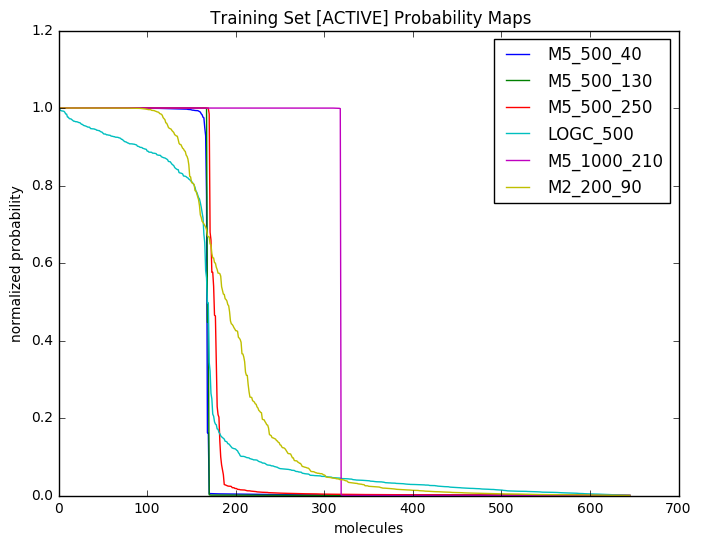

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from sklearn.preprocessing import minmax_scale

def sort_map(column):
    array = minmax_scale(train_results[column])
    return array[np.argsort(-array)]

scale = 1.0
fig = plt.figure(num=None, figsize=(8 * scale, 6 * scale), dpi=80, facecolor='w', edgecolor='k')
for map in all_active: plt.plot(sort_map(map), label=map)
xlabel("molecules")
ylabel("normalized probability")
title(" Training Set [ACTIVE] Probability Maps")
legend(loc=1); # upper right corner

#### Commentary.

* Very rapid DNN convergence. We see that the probability map for M5_500_40 has converged to a step function in 40 epochs.
* All of the probability maps with the exception of M2_200_90 approximate step functions.
* **Key question**, What exemplar molecules were added to the [ACTIVE] training set when moving from EC50_200 to EC50_500?



## Molecular Classification.

This section examines training and test molecules that are classified by EC50_200, EC50_500 and EC50_1000. The python code comes from Greg Landrum's blog posts.
You must be in an anaconda (or other) python environment that has previously setup rdkit to execute this code.

The python code below generates the following data_frames:

* ec50_200_active [ACTIVE] training molecules in EC50_200
* ec50_500_active [ACTIVE] training molecules in EC50_500
* ec50_500_added the added [ACTIVE] training molecules ec50_500_active - ec50_200_active 
* ec50_1000_active [ACTIVE] training molecules in EC50_1000
* ec50_1000_added the added [ACTIVE] training molecules ec50_1000_active - ec50_500_active 

The code also generates the rdkit mols and labels for use is displaying moles.

The labels have the following form: *"1 MMV669304 A A 280 (1.000)"*

* The number *"1"* is the position of the molecule in the data_frame. This is only meaningful if the data_frame has been sorted.
* Molecular ID *"MMV669304"*
* The first *"A"* indicates if the molecule is [ACTIVE] at EC50 <= 500nMol. Values are [ACTIVE] = "A", [INACTIVE] = "I".
* The second *"A"* is the PfATP4 ION_ACTIVITY class. Values are [ACTIVE] = "A", [INACTIVE] = "I", [PARTIAL] = "P", no ION_ACTIVITY assay = "X".
* *"280"* is the EC50 assay in nMols.
* *"(1.000)"* is the M5_500_250 probability map value of the molecule. For training set molecules this will always be close 1.000. 


In [6]:
ec50_200_active = train_results.loc[train_results["ACTUAL_200"] == "ACTIVE"] # all EC50_200 [ACTIVE] molecules
ec50_200_active_list = ec50_200_active["ID"].tolist() 
ec50_500_active = train_results.loc[train_results["ACTUAL_500"] == "ACTIVE"]  # all EC50_500 [ACTIVE] molecules
ec50_500_active_list = ec50_500_active["ID"].tolist()
added_ec50_500_list = list(set(ec50_500_active_list) - set(ec50_200_active_list))
ec50_500_added = train_results.loc[train_results["ID"].isin(added_ec50_500_list)]  # all added EC50_500 [ACTIVE] molecules
ec50_1000_active = train_results.loc[train_results["ACTUAL_1000"] == "ACTIVE"]  # all EC50_1000 [ACTIVE] molecules
ec50_1000_active_list = ec50_1000_active["ID"].tolist()
added_ec50_1000_list = list(set(ec50_1000_active_list) - set(ec50_500_active_list))
ec50_1000_added = train_results.loc[train_results["ID"].isin(added_ec50_1000_list)]  # all added EC50_1000 [ACTIVE] molecules

def mol_label_list(data_frame):  # Function to produce rdkit mols and associated molecular labels
    id = data_frame["ID"].tolist()
    klass =  data_frame["ACTUAL_500"].tolist()
    potency = data_frame["EC50"].tolist()
    ion_activity = data_frame["ION_ACTIVITY"].tolist()
    map_prob = data_frame["M5_500_250"].tolist()
    labels = []
    for idx in range(len(id)):
        labels.append("{} {} {} {} {:5.0f} ({:5.4f})".format(idx+1, id[idx],
                                                           klass[idx][0], ion_activity[idx][0],
                                                           potency[idx]*1000, map_prob[idx]))
    smiles = data_frame["SMILE"].tolist()
    mols = [Chem.MolFromSmiles(smile) for smile in smiles]
    return mols, labels

print("len(ec50_200_active):", len(ec50_200_active), "len(ec50_500_active):", len(ec50_500_active),
      "len(ec50_500_added):", len(ec50_500_added), "len(ec50_1000_active):", len(ec50_1000_active),
      "len(ec50_1000_added):", len(ec50_1000_added))



('len(ec50_200_active):', 71, 'len(ec50_500_active):', 169, 'len(ec50_500_added):', 98, 'len(ec50_1000_active):', 319, 'len(ec50_1000_added):', 150)


In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
IPythonConsole.ipython_useSVG=True

####  ION_ACTIVITY [ACTIVE] in EC50_200

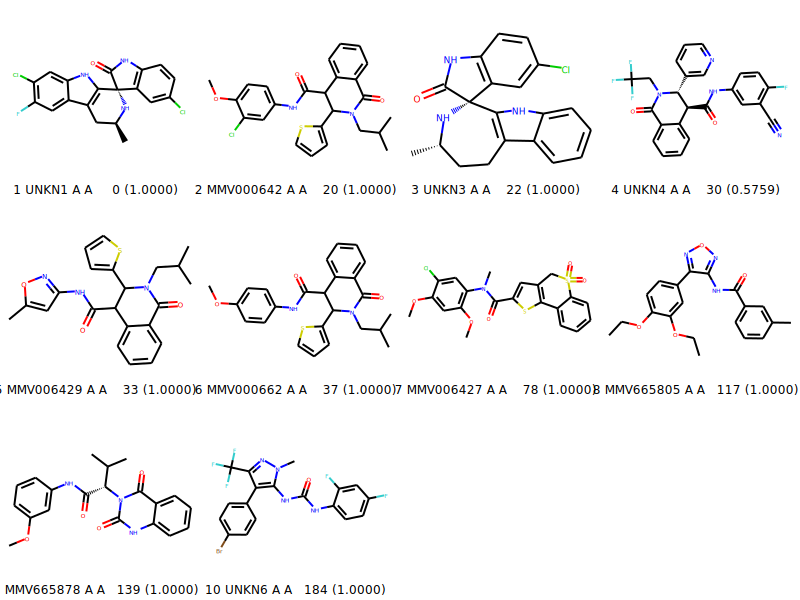

In [8]:
ion_active = ec50_200_active.loc[train_results["ION_ACTIVITY"] == "ACTIVE"].sort_values("EC50")
mols, labels = mol_label_list(ion_active)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

####  ION_ACTIVITY [ACTIVE] Exemplar molecules that were added to the training set when moving from EC50_200 to EC50_500

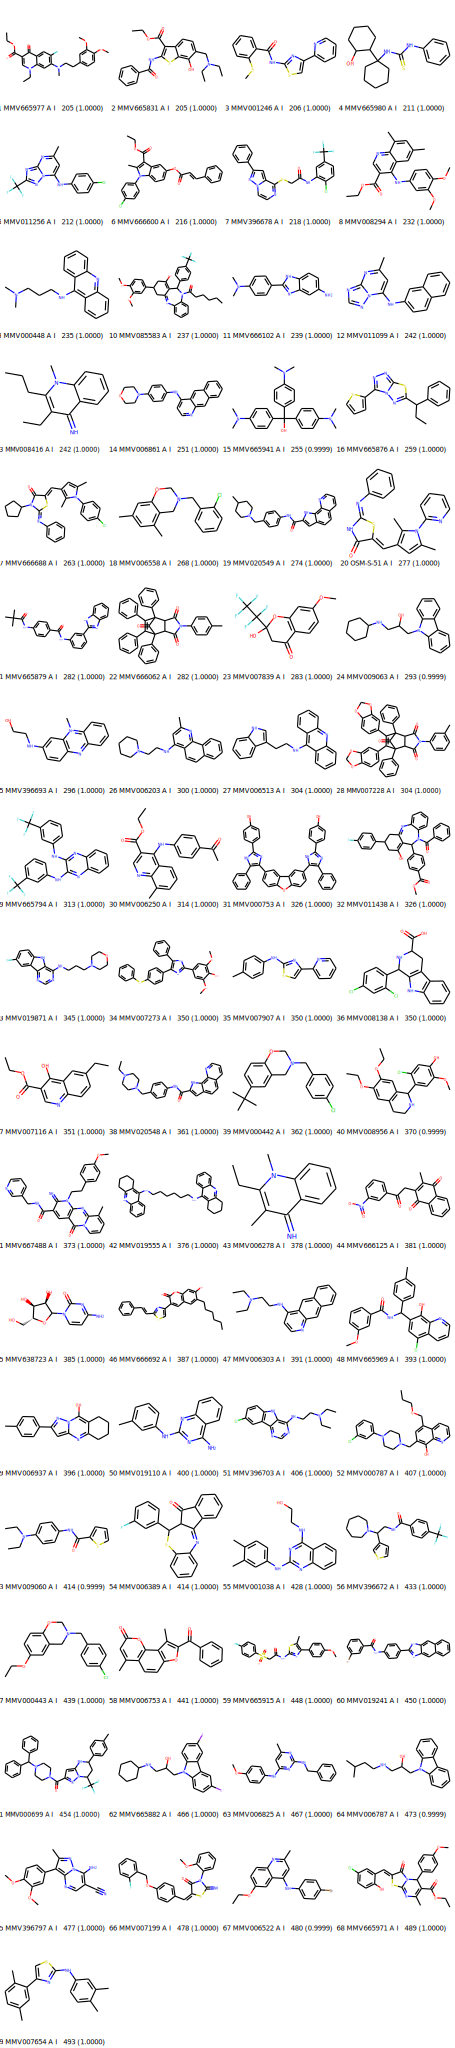

In [13]:
ion_active = ec50_500_added.loc[train_results["ION_ACTIVITY"] == "INACTIVE"].sort_values("EC50")
mols, labels = mol_label_list(ion_active)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

#### Commentary

These molecules have the same Triazole arm as we noticed in the previous notebook when trying to classifiy the molecular ION_ACTIVITY using D840_ACTIVE (DRAGON). This structure is also well represented in the test molecules.

####  ION_ACTIVITY [ACTIVE] Exemplar molecules that were added to the training set when moving from EC50_500 to EC50_1000

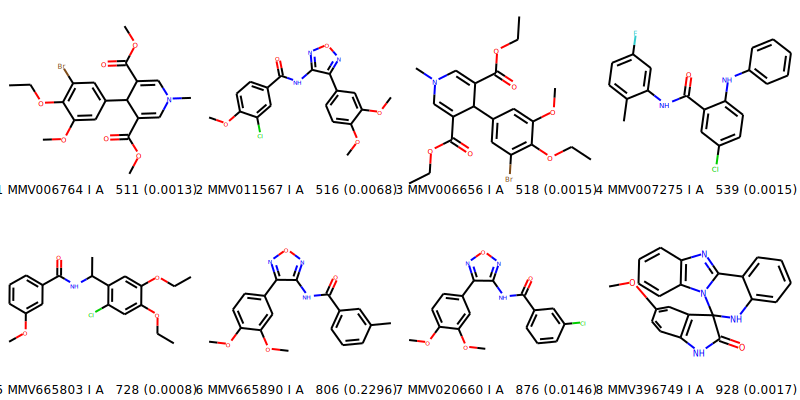

In [10]:
ion_active = ec50_1000_added.loc[train_results["ION_ACTIVITY"] == "ACTIVE"].sort_values("EC50")
mols, labels = mol_label_list(ion_active)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

####  The results of the EC50_500 classification of the test molecules.  

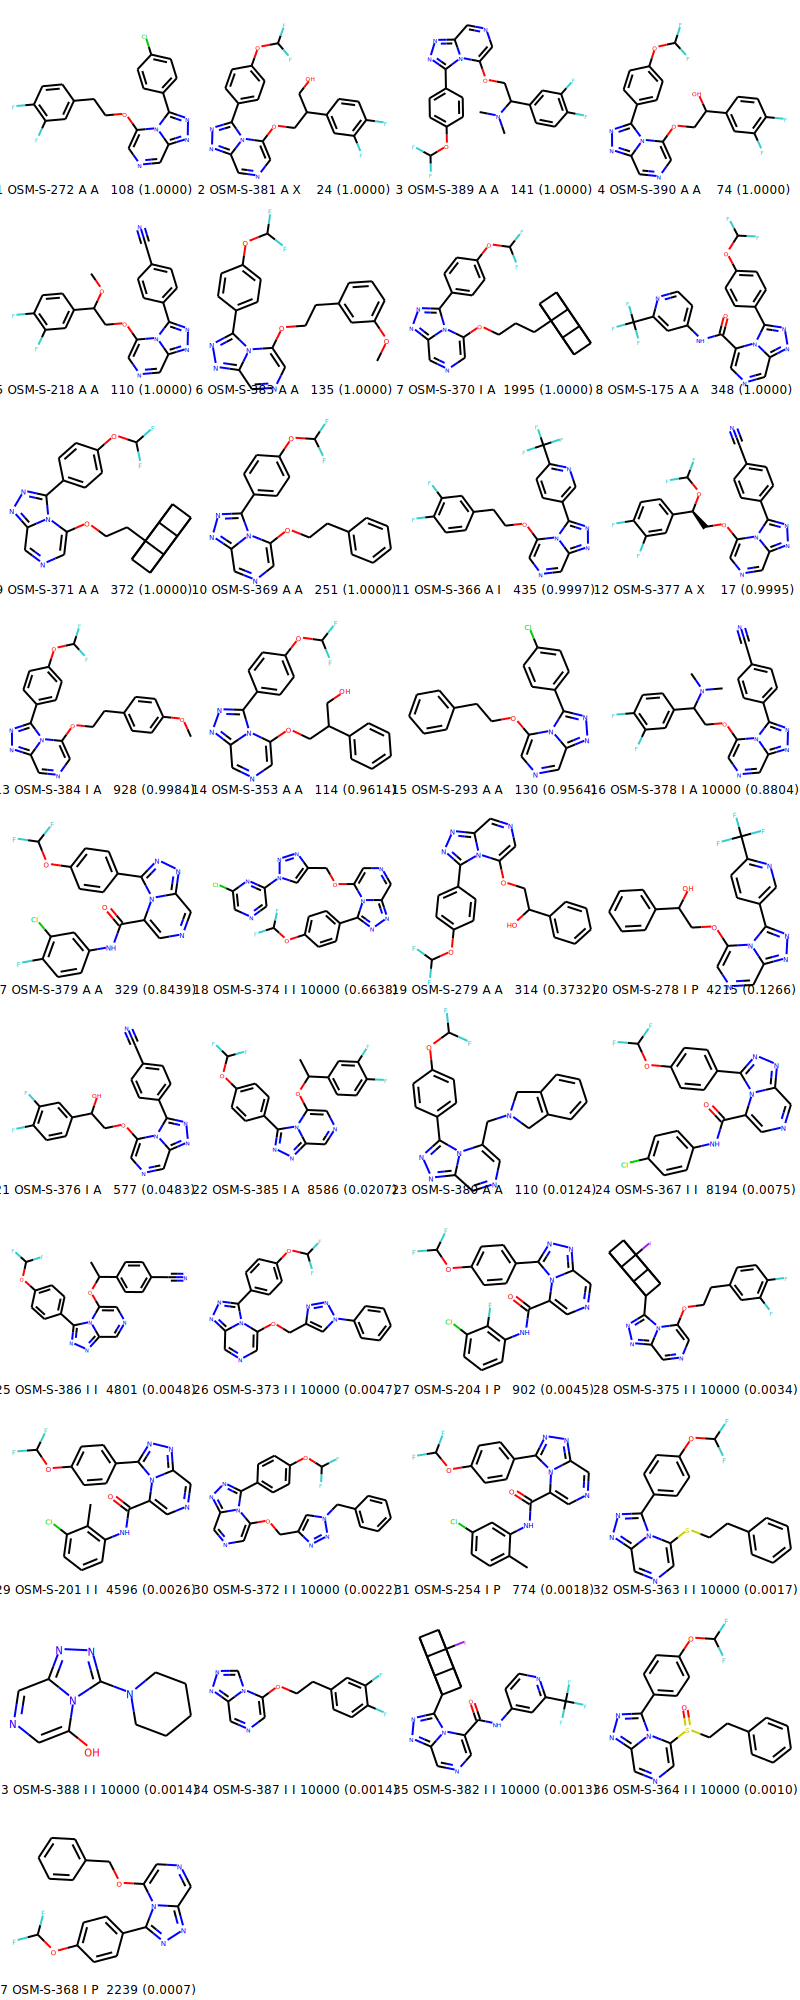

In [11]:
sorted = test_results.sort_values("M5_500_250", ascending=False)
mols, labels = mol_label_list(sorted)
Draw.MolsToGridImage(mols,legends=labels,molsPerRow=4)

#### Commentary

* The immediate and possibly very important observation is the "false positive" test molecules that were incorrectly identified as ION_ACTIVITY [ACTIVE] by the D840_ACTIVE (DRAGON) classifier in the previous notebook; OSM-S-367 and OSM-S-201 [INACTIVE] and OSM-S-204 [PARTIAL] are now classified as very low probability of being EC50_500 [ACTIVE] by the M5_500_250 classifier.

* This may be the link we are looking for between ION_ACTIVITY and EC50. And suggests a two stage selection methodology.

    1. Use the D840_ACTIVE (DRAGON) classifier described in the previous notebook to select likely molecular structures, including false positive candidates such as OSM-S-367, OSM-S-201 and OSM-S-204.

    2. Then triage the candidates by predicting EC50_500 activity using M5_500_250. This would then exclude OSM-S-367, OSM-S-201 and OSM-S-204.

* What about "false negatives". OSM-S-371 and OSM-S-370 are ION_ACTIVITY [ACTIVE] but are classified by D840_ACTIVE as 31/35 and 32/35 ([INACTIVE]) respectively because the structure of the Pyridine arm of these molecules is quite different to that of highly ranked molecules. However, M5_500_250 classifies these molecules as EC50_500 [ACTIVE] (prob 1.000). Using the procedure described above these molecules would be excluded at the first round. Although this represents wasted opportunity, not wasted effort.

* We could just use the EC50_500 molecule classification as a proxy for ION_ACTIVITY classification. This would solve the "false negative" problem but introduces new "false positives" such as OSM-S-366. 



##### Using EC50_500 to predict ION_ACTIVITY

The python code below uses the molecule ION_ACTIVITY class and the probability map from M5_500_250 and LOGC_500 to calculate the AUC score we would generate by using EC50_500 to predict ION_ACTIVITY. 

In [12]:
from sklearn.metrics import roc_auc_score

# Get the M5_500_250 prob vector

prob = test_results["M5_500_250"].tolist()

# Get the LOGC_500 prob vector

logc_prob = test_results["LOGC_500"].tolist()

# Get the ION ACTIVITY vector 

ion = test_results["ION_ACTIVITY"].tolist()

# Filter out molecules without an ion assay and convert ION_ACTIVITY to a binary vector [PARTIAL] = [INACTIVE]

filter_prob = []
filter_logc_prob = []
filter_ion = []
for idx in range(len(prob)):
    
    if ion[idx] == "ACTIVE":
        filter_prob.append(prob[idx])
        filter_logc_prob.append(logc_prob[idx])
        filter_ion.append(1)
    elif ion[idx] == "INACTIVE" or ion[idx] == "PARTIAL":
        filter_prob.append(prob[idx])
        filter_logc_prob.append(logc_prob[idx])
        filter_ion.append(0)
                
ion_auc = roc_auc_score(filter_ion, filter_prob, average=None, sample_weight=None)

ion_logc_auc = roc_auc_score(filter_ion, filter_logc_prob, average=None, sample_weight=None)

print("AUC when using M5_500_250 to predict ION_ACTIVITY:", ion_auc)
print("AUC when using LOGC_500 to predict ION_ACTIVITY:", ion_logc_auc)

('AUC when using M5_500_250 to predict ION_ACTIVITY:', 0.94771241830065356)
('AUC when using LOGC_500 to predict ION_ACTIVITY:', 0.92810457516339873)


#### Commentary

## Using EC50_500 to predict ION_ACTIVITY generates an AUC = 0.95 using a custom Neural Network and AUC = 0.93 using an "off-the-self" logistic classifier.

This could be the solution to the problem of classifying ION_ACTIVITY.

#### Similarity Maps

The LOGC_500  similarity maps (step functions such as M5_500_250 may not work well with similarity maps) for OSM-S-379 [ACTIVE], OSM-S-367 [INACTIVE], OSM-S-201 [INACTIVE], OSM-S-204[INACTIVE], OSM-S-370 [ACTIVE] and OSM-S-371 [ACTIVE] are displayed below.

##### OSM-S-367 

![OSM_S_367](OSM-S-367_logc.png)

##### OSM-S-379

![OSM_S_379](OSM-S-379_logc.png)

##### OSM-S-201

![OSM_S_201](OSM-S-201_logc.png)

##### OSM-S-204

![OSM_S_204](OSM-S-204_logc.png)

##### OSM-S-370

![OSM_S_370](OSM-S-370_logc.png)

##### OSM-S-371

![OSM_S_371](OSM-S-371_logc.png)